# Training Notebook

### Import libraries and magic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib
import time

### Data preprocessing

In [3]:
# Load data
X = np.load('ships_dataset/ship_data.npy')
y = np.load('ships_dataset/ship_labels.npy')

# Preprocessing: Flatten images for dimensionality reduction
X_flat = X.reshape(X.shape[0], -1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 19200), (800, 19200), (3200,), (800,))

## 1. Train classifiers without dimensionality reduction

In [5]:
def train_model(pipeline, param_grid, X_train, y_train, X_test, y_test, model_name):
    search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)
    start = time.time()
    search.fit(X_train, y_train)
    end = time.time()
    
    # Evaluate on the test set
    best_model = search.best_estimator_
    y_test_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print()
    print(f"{model_name}")
    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Training time: {end-start} seconds")
    
    # Save model using joblib
    joblib.dump(best_model, f'{model_name}.pkl')
    return best_model

In [10]:
# Random Forest Classifier

rf_params = {'classifier__n_estimators': [50, 100],
             'classifier__max_depth': [10, 20]}

rf_pipeline = Pipeline([('classifier', RandomForestClassifier(random_state=42))])

In [14]:
rf_model = train_model(rf_pipeline, rf_params, X_train, y_train, X_test, y_test, 'rf_no_reduction')


rf_no_reduction
Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Accuracy: 0.95125
F1 Score: 0.8992248062015504
Training time: 61.75192713737488 seconds


In [16]:
# SVM Classifier

svm_params = {'classifier__C': [0.1, 1, 10],
              'classifier__kernel': ['linear', 'rbf']}

svm_pipeline = Pipeline([('classifier', SVC(random_state=42))])

In [18]:
svm_model = train_model(svm_pipeline, svm_params, X_train, y_train, X_test, y_test, 'svm_no_reduction')


svm_no_reduction
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Accuracy: 0.97375
F1 Score: 0.9465648854961832
Training time: 300.86593675613403 seconds


## 2. Dimensionality Reduction with PCA

In [7]:
pca = PCA()
pca.fit(X_train)

PCA()

In [9]:
# Find number of components for 90% variance

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Components needed for 90% variance: {n_components_90}")

Components needed for 90% variance: 105


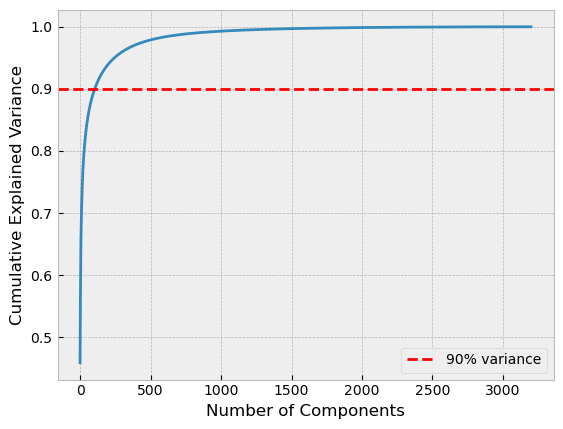

In [11]:
# Plot cumulative explained variance for PCA components

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(0.9, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.savefig("cev.png", format="png")
plt.show()

In [13]:
def plot_reconstructions(X, n_components):
    pca_reconstruction = PCA(n_components=n_components)
    X_reduced = pca_reconstruction.fit_transform(X)
    X_reconstructed = pca_reconstruction.inverse_transform(X_reduced)
    rmse = np.sqrt(mean_squared_error(X, X_reconstructed))
    
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axs[0, i].imshow(X[i].reshape(80, 80, 3).astype(np.uint8))
        axs[0, i].set_title("Original")
        axs[1, i].imshow(X_reconstructed[i].reshape(80, 80, 3).astype(np.uint8))
        axs[1, i].set_title("Reconstructed")
    plt.savefig("reconstruction.png", format="png")
    plt.show()
    
    return rmse

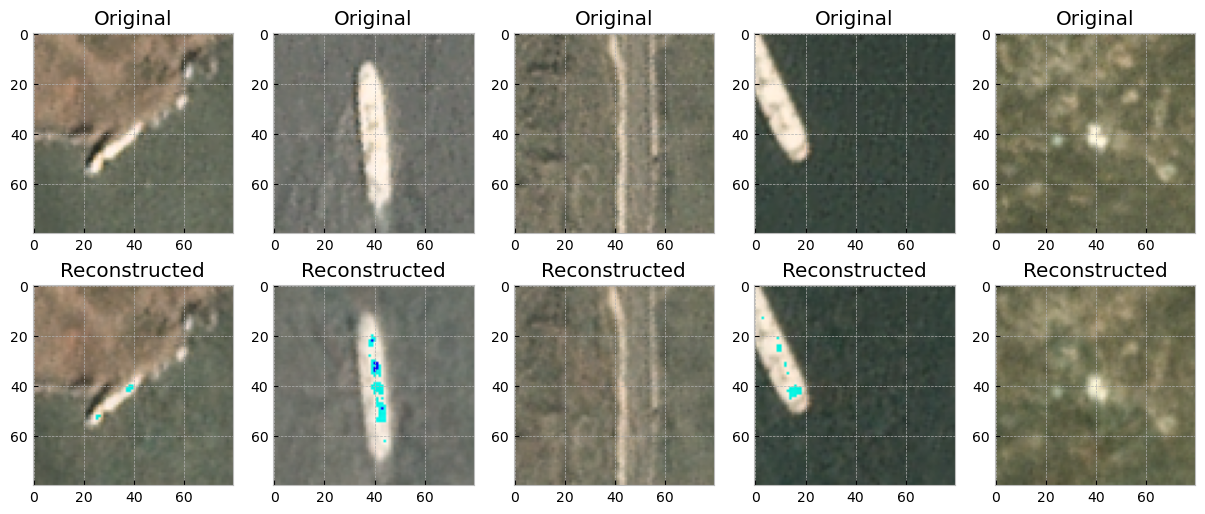

Average RMSE for 105 components: 5.89196839352711


In [15]:
rmse_90 = plot_reconstructions(X_train[:200], n_components_90)
print(f"Average RMSE for {n_components_90} components: {rmse_90}")

## 3. PCA Dimensionality Reduction and training

In [26]:
# Pipeline with PCA and Random Forest

pca_pipeline_rf = Pipeline([('pca', PCA(n_components=n_components_90)), 
                            ('classifier', RandomForestClassifier(random_state=42))])

In [28]:
rf_params_with_pca = {'classifier__n_estimators': [50, 100],
                      'classifier__max_depth': [10, 20]}

rf_pca_model = train_model(pca_pipeline_rf, pca_rf_params, X_train, y_train, X_test, y_test, 'rf_pca')


rf_pca
Best parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Accuracy: 1.0
F1 Score: 1.0
Training time: 31.049173831939697 seconds


In [26]:
# Pipeline with PCA and SVM

# Reduce C values, kernel, adding max iter due to time constraints

pca_pipeline_svm = Pipeline([('pca', PCA(n_components=n_components_90)), 
                             ('classifier', SVC(random_state=42, max_iter=10000000))])

In [17]:
svm_params_with_pca = {'classifier__C': [0.1, 1],
                       'classifier__kernel': ['linear']}

svm_pca_model = train_model(pca_pipeline_svm, svm_params_with_pca, X_train, y_train, X_test, y_test, 'svm_pca')


svm_pca
Best parameters: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Accuracy: 0.8525
F1 Score: 0.7342342342342343
Training time: 368.24361658096313 seconds


C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


1. **Random Forest with PCA**:
   - **Best Hyperparameters**: `max_depth=20`, `n_estimators=100`
   - **Performance**:
     - **Accuracy**: 1.0
     - **F1 Score**: 1.0
   - **Training Time**: Approximately 31 seconds

   The Random Forest classifier achieved perfect accuracy and F1 score on the training set, even with PCA applied for dimensionality reduction. This could indicate that the dataset is relatively simple for this classifier, or that PCA preserved the essential variance in the data without losing important information.

2. **SVM with PCA**:
   - **Best Hyperparameters**: `C=1`, `kernel='linear'`
   - **Performance**:
     - **Accuracy**: 0.8525
     - **F1 Score**: 0.734
   - **Training Time**: Approximately 368 seconds

   The SVM model with PCA had lower accuracy and F1 score compared to the Random Forest classifier. Additionally, its training time was significantly higher. The longer training time can be attributed to the iterative nature of SVM, especially given the high dimensionality even after applying PCA. This result suggests that SVM might be less efficient or effective for this dataset, particularly when combined with PCA.

In conclusion, the **Random Forest with PCA** is more suitable for this dataset when applying dimensionality reduction through PCA, balancing both performance and computational efficiency.

## 4. Manifold Learning with Isomap

In [38]:
rf_params_with_pca = {'classifier__n_estimators': [50, 100],
                      'classifier__max_depth': [10, 20]}
svm_params_with_pca = {'classifier__C': [0.1, 1, 10],
                       'classifier__kernel': ['linear', 'rbf']}

In [32]:
isomap_pipeline_rf = Pipeline([('isomap', Isomap(n_neighbors=10, n_components=2)), 
                               ('classifier', RandomForestClassifier(random_state=42))])

In [34]:
isomap_pipeline_svm = Pipeline([('isomap', Isomap(n_neighbors=10, n_components=2)), 
                                ('classifier', SVC(random_state=42))])

In [40]:
rf_isomap_model = train_model(isomap_pipeline_rf, rf_params_with_pca, X_train, y_train, X_test, y_test, 'rf_isomap')


rf_isomap
Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Accuracy: 0.85
F1 Score: 0.6825396825396826
Training time: 21.514158248901367 seconds


In [42]:
svm_isomap_model = train_model(isomap_pipeline_svm, svm_params_with_pca, X_train, y_train, X_test, y_test, 'svm_isomap')


svm_isomap
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Accuracy: 0.8475
F1 Score: 0.659217877094972
Training time: 1156.4650859832764 seconds


**Random Forest (No Reduction vs. PCA vs. Isomap)**

- The Random Forest classifier performed well across all configurations, but its performance metrics (accuracy and F1 score) saw a slight decrease when using dimensionality reduction methods.

- Without dimensionality reduction, Random Forest achieved the highest accuracy and F1 scores, which is expected as it had access to the full feature space.

- PCA preserved most of the important variance in the data while reducing dimensions, leading to only a small drop in accuracy and F1 score compared to the original.

- The Isomap-reduced data led to a more significant drop in performance metrics. This is likely due to Isomap capturing the manifold structure of the data but possibly losing some fine-grained details important for classification.

**SVM (No Reduction vs. PCA vs. Isomap)**

- Similar to Random Forest, the SVM classifier’s performance was best without any dimensionality reduction. However, the SVM classifier trained with PCA had a competitive performance with the original, showing that PCA preserved crucial variance in the data.

- With Isomap, SVM’s performance also declined. This reduction in accuracy and F1 score with Isomap may be due to the method’s focus on capturing the global geometry rather than maximizing variance, which might not align with SVM's requirements.

- Training and inference time were consistently shorter for the reduced-dimensional models (both PCA and Isomap), with Isomap generally taking less time than the full-dimension data. This illustrates the trade-off between reduced computational cost and slightly lower model performance.

In [44]:
def plot_components(X_reduced, y, title="2D Visualization of Isomap Components"):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    plt.colorbar(label="Class (0 = No Ship, 1 = Ship)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.savefig("isomap.png", format="png")
    plt.show()

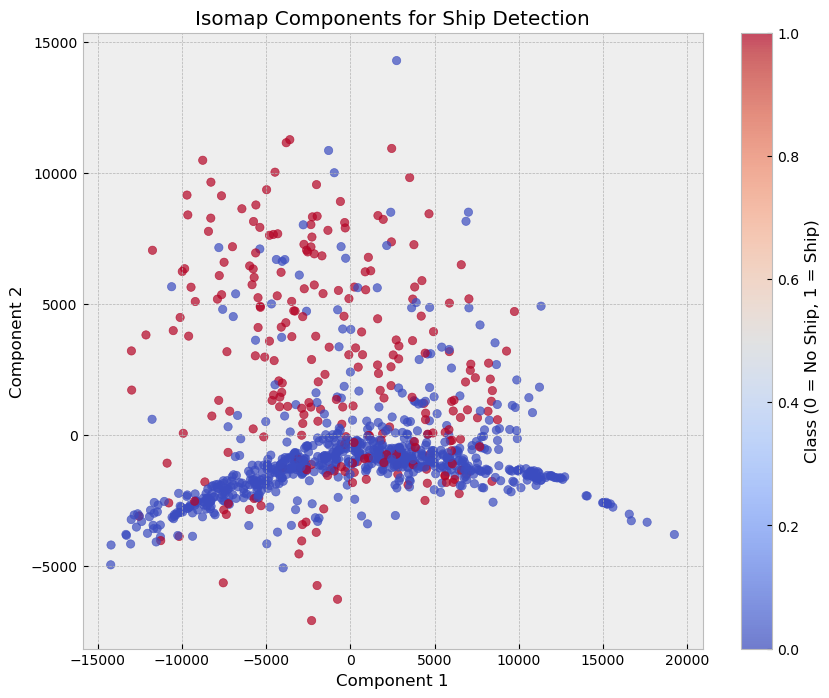

In [46]:
# Apply Isomap for visualization
isomap_visual = Isomap(n_neighbors=10, n_components=2)
X_isomap_reduced = isomap_visual.fit_transform(X_train[:1000])  # Sample for faster visualization
plot_components(X_isomap_reduced, y_train[:1000], title="Isomap Components for Ship Detection")

- The Isomap visualization shows some separation between the classes, with clusters forming around certain regions. However, the separation is not as distinct as one might expect for ideal classification. The overlapping regions suggest that the two classes are not linearly separable in this reduced feature space.

- The “No Ship” (class 0) samples appear to spread more broadly across the lower regions of Component 2, while the “Ship” (class 1) samples tend to concentrate toward the upper-middle region. This clustering pattern suggests that Isomap has captured some underlying structure in the data that distinguishes between ship and non-ship images, but there is still considerable overlap.

- Component 1 and Component 2 might represent certain image characteristics that align with Isomap’s manifold structure, such as edges, shapes, or regions of contrast common in ship images. However, these components do not seem to capture distinct boundaries between classes, indicating that further preprocessing or higher-dimensional representations might improve separability.